# Hashtag Analysis and relationship with MMR graph data

In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from collections import Counter
import re

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "6.HashtagAnalysis")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [2]:
def backup_graph(graph, filename):
    FOut = snap.TFOut("../data/"+filename+".bin")
    graph.Save(FOut)
    FOut.Flush()
    
def load_graph_from_backup(filename):
    FIn = snap.TFIn("../data/"+filename+".bin")
    graph = snap.TUNGraph.Load(FIn)
    return graph

In [3]:
hashtag = "brexit"
hashtag_full = "#Brexit"

In [4]:
# Import the biggest connected component to work on
#graph = load_graph_from_backup("mmr_max_connected_component")

In [5]:
# %load ../scripts/def_get_multiple_usernames.py
def get_multiple_usernames(ids):
    # Convert ID to line number by adding 1
    arg = ";".join([str(el + 1) + "p" for el in ids])

    #Invoke shell script that finds the occurrences
    p = subprocess.Popen(['../scripts/get_usernames.sh', arg], stdout=subprocess.PIPE)
    output = p.communicate()[0]

    id_to_username_dict = {line.split(',')[1]:line.split(',')[0] for line in output.split('\n') if line != ""}
    return id_to_username_dict

In [6]:
def cast_df_to_original_types(df, columns, df_types_dict):
    for column in columns:
        df[column] = df[column].astype(df_types_dict[column])

In [7]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')
        
def get_relative_percentage(n,m):
    return n*100.0/m

## Read Tweets from file

In [8]:
%%time
tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
tweets = []
with open(tweets_filename) as fin:
    for line in read_large_file(fin):
        tweets.append(json.loads(line))
print("Imported %d tweets from %s" %(len(tweets),tweets_filename))

Imported 3056604 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#brexit_2013-09-01_2016-12-31.json
CPU times: user 1min 41s, sys: 6.9 s, total: 1min 47s
Wall time: 1min 47s


Given the main graph, I have to identify the subgraph of nodes (usernames) that have been part of a Twitter conversation that involved the concerned hashtag. This means that I would consider node $i$ part of the subnet if one of the following occurs:
- $i$ has **tweeted** using hashtag $h$;
- $i$ has been **mentioned**/**replied to** by someone that used hashtag $h$;
- $i$ has tweeted a status that has been **retweeted**/**quoted** by someone else that used hashtag $h.$

Of course this operation is not immediate and trivial, since the usernames will be collected first as a set of actual Twitter screen names, which have to be mapped to their specific encoding afterwards.

# 1. Extract Hashtag Subgraph
Let's collect all the usernames from the downloaded tweets and keep only the ones that are part of our MMR data.

In [9]:
def get_usernames_from_basic_tweet_info(hashtag, tweet):
    usernames = set()
    # (1): Has tweeted using hashtag
    if hashtag in [h.lower() for h in tweet["entities"]["hashtags"]]:
        usernames.add(tweet["user"]["screen_name"].lower())

    # (2): Has been mentioned / replied to
    if not tweet["in_reply_to_screen_name"] is None:
        usernames.add(tweet["in_reply_to_screen_name"].lower())
    for mentions in tweet["entities"]["user_mentions"]:
        usernames.add(mentions["screen_name"].lower())
    return usernames

def extract_hashtag_usernames(hashtag, tweets):
    hashtag_usernames = set()
    for tweet in tweets:
        hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet))
   
        # (3): Retweeted / Quoted status
        if "retweeted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["retweeted_status"]))
        if "quoted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["quoted_status"]))
    print("Total unique usernames involved in '#%s' hashtag conversations from %d tweets: %d" %(hashtag, len(tweets), len(hashtag_usernames)))
    return hashtag_usernames

In [10]:
hashtag_usernames = extract_hashtag_usernames(hashtag, tweets)

Total unique usernames involved in '#brexit' hashtag conversations from 3056604 tweets: 790224


Let's now find the corresponding encoding for the usernames existing in the MMR graph data:

In [11]:
%%time
# First load all usernames in memory
usernames_to_id_dict = {}
with open("../data/usernames.csv") as usernames_f:
    for line in read_large_file(usernames_f):
        username = line.split(',')[0]
        encoding = int(line.split(',')[1])
        usernames_to_id_dict[username] = encoding

CPU times: user 2min 57s, sys: 6.84 s, total: 3min 4s
Wall time: 3min 4s


In [12]:
%%time
# Filter usernames
usernames_to_id_dict = { k:v for k,v in usernames_to_id_dict.iteritems() if k in hashtag_usernames }

CPU times: user 43.5 s, sys: 972 ms, total: 44.5 s
Wall time: 43.8 s


At this point, all the values of the `usernames_to_id_dict` represent node IDs in the MMR graph so it's trivial to extract the subnet of nodes having some IDs:

In [13]:
# Get subgraph
NIdV = snap.TIntV()
for node_id in usernames_to_id_dict.itervalues():
    NIdV.Add(node_id)
hashtag_subgraph = snap.GetSubGraph(graph, NIdV)

Let's show some summary statistics:

In [14]:
tab_format = "{0: <65} {1}"
print(tab_format.format("Total Tweets for hashtag '%s': " %hashtag, len(tweets)))
print(tab_format.format("Total unique usernames found in tweets: ", len(hashtag_usernames)))
print(tab_format.format("Total usernames within ORIGINAL MMR data: ", str(len(usernames_to_id_dict)) + " (%2.f%% of %d)" %(len(usernames_to_id_dict)*100.0/len(hashtag_usernames), len(hashtag_usernames))))
print(tab_format.format("Total usernames within CLEANED MMR data and biggest component: ", str(hashtag_subgraph.GetNodes()) + " (%.2f%% of %d)" %(hashtag_subgraph.GetNodes()*100.0/len(usernames_to_id_dict), len(usernames_to_id_dict))))
print(tab_format.format("Size of subgraph compared to full graph: ", "%.2f%%" %(hashtag_subgraph.GetNodes()*100.0/graph.GetNodes())))

Total Tweets for hashtag 'brexit':                                3056604
Total unique usernames found in tweets:                           790224
Total usernames within ORIGINAL MMR data:                         493432 (62% of 790224)
Total usernames within CLEANED MMR data and biggest component:    485595 (98.41% of 493432)
Size of subgraph compared to full graph:                          0.57%


In [15]:
# Create binary backup of subgraph, for easy re-import
#backup_graph(hashtag_subgraph, "mmr_subgraph_"+hashtag)

In [5]:
# Import the hashtag subgraph to work on
#hashtag_subgraph = load_graph_from_backup("mmr_subgraph_"+hashtag)

Overall, **62%** of the users who tweeted about **#Brexit** have been captured by the MMR graph data (*potentially available hashtag data*). **98,41%** of usernames in the potentially available hashtag data are part of the cleaned data and the largest connected component. This means that the cleanup process from the previous chapters didn't significantly impact the amount of available data. Furthermore, the amount of nodes the are going to be analyzed from now on represent the **0,57%** of the global MMR data. For convenience, the extracted subgraph will be called $H$ in the next sections. 

# 2. Temporal Frequency Distribution of the hashtag
As a first step of the hashtag analysis, we first want to do some basic processing on the downloaded tweets and figure out how much the utilization of such hashtag is spread throughout the time-window we're focusing on (September 2013 - December 2019).

In [16]:
def get_tweet_users(tweet):
    users = set()
    users.add(tweet["user"]["screen_name"].lower())
    if not tweet["in_reply_to_screen_name"] is None:
        users.add(tweet["in_reply_to_screen_name"].lower())
    for mention in tweet["entities"]["user_mentions"]:
        users.add(mention["screen_name"].lower())
    if "retweeted_status" in tweet:
        users.update(get_tweet_users(tweet["retweeted_status"]))
    if "quoted_status" in tweet:
        users.update(get_tweet_users(tweet["quoted_status"]))
    return users

def collect_tweets_dates(tweets, graph_usernames):
    all_dates = []
    subgraph_dates = []
    graph_usernames_set = set(graph_usernames) # Membership check is much faster for sets than lists
    print("Collecting tweets dates...")
    for tweet in tweets:
        date = datetime.datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').date()
        all_dates.append(date)
        if any([username in graph_usernames_set for username in get_tweet_users(tweet)]):
            subgraph_dates.append(date)
    print("Done! Total dates: %d\nSubgraph dates: %d" %(len(all_dates), len(subgraph_dates)))
    return all_dates, subgraph_dates

def plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag, legend_pos="upper right"):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    mpl_data1 = mdates.date2num(all_tweets_dates)
    mpl_data2 = mdates.date2num(subgraph_tweets_dates)
    
    # Generate bins (we have 13 fixed periods starting from 2013-09-01)
    bins = [mdates.date2num(datetime.date(2013,9,1) + relativedelta(months=(3*i))) for i in range(14)]
    
    ax.hist([mpl_data1, mpl_data2], bins=bins, label=["All Users", "Only MMR Users"], align="mid", rwidth=0.5)
    
    # Set legend
    ax.legend(loc=legend_pos)
    
    # Axes labels
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlabel("Periods", fontsize=12, fontweight="bold")
    
    # Axes ticks and formatting
    #locator = mdates.AutoDateLocator()
    #ax.xaxis.set_major_locator(locator)
    #ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.grid(False)
    plt.xticks(bins, rotation="20",fontsize=10) # Show xticks underneath bars
    plt.yticks(fontsize=10)
    
    plt.title("%s Hashtag Frequency Distribution over the years" %hashtag)
    plt.savefig(os.path.join(pictures_path,hashtag+"_Frequency_Distribution.png"))
    fig.set_tight_layout(False)
    plt.show()

In [17]:
%%time
# Collect tweets dates
all_tweets_dates, subgraph_tweets_dates = collect_tweets_dates(tweets, usernames_to_id_dict.keys())

Done! Total dates: 3056604
Subgraph dates: 2394685
CPU times: user 57.8 s, sys: 48 ms, total: 57.8 s
Wall time: 57.8 s


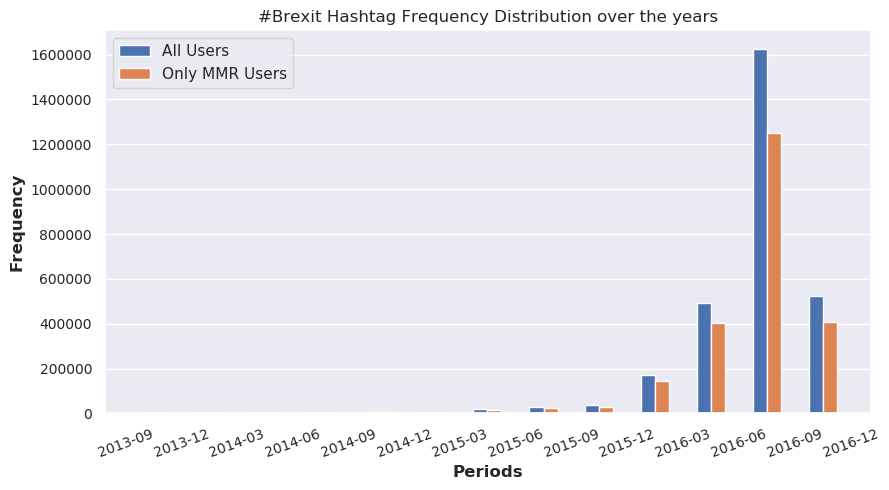

In [18]:
# Plot hashtag frequency distribution
plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag_full, legend_pos="upper left")

# 3. Hashtag Subgraph Metric Analysis

## 3.1 Basic Subnetwork Properties
Hereby I show how the basic network properties of $H$ change compared to the full MMR graph, in terms of number of nodes $N$, number of links $L$ and average degree $\langle K \rangle$.

In [19]:
N = hashtag_subgraph.GetNodes()
L = hashtag_subgraph.GetEdges()
K = (2.0*L)/N
print("Nodes of H: %d" %N)
print("Edges of H: %d" %L)
print("Average Degree of H: %.3f" %K)

Nodes of H: 485595
Edges of H: 3430912
Average Degree of H: 14.131


| Property | $G$ (SCC) | $H$ (Hashtag Subgraph) | % Relative to $G$
|---|---|---|---|
| **Average Degree $\langle K \rangle$** | 10,127 | 14,131 | -
| **Number of nodes $N$** | 84.510.806 | 485.595 | ~0,57%
| **Number of edges $L$** | 427.935.499 | 3.430.912 | ~0,8%

## 3.2 Extract Random Graphs
It would be interesting to compare a set of network properties of $H$ with the ones of $M=100$ random subgraphs *of the same size* $N$.

In [20]:
def get_random_subgraphs(graph, M, N):
    return [snap.GetRndSubGraph(graph,N) for _ in range(M)]

In [21]:
%%time
M = 100
random_subgraphs = get_random_subgraphs(graph, M, N)

CPU times: user 10min 48s, sys: 12 s, total: 11min
Wall time: 11min


In [22]:
# Backup random subgraphs
'''for i,rnd in enumerate(random_subgraphs):
    backup_graph(rnd,"random_subgraphs/%s_random%d" %(hashtag,i))'''

In [ ]:
# Load random subgraphs
#random_subgraphs = [load_graph_from_backup("random_subgraphs/%s_random%d" %(hashtag,i)) for i in range(M)]

In [23]:
def plot_random_subgraphs_property_distribution(data, hashtag, filename, M, N, labels_dict, rwidth, discrete_values=False, binwidth=1, legend_pos="upper right", x_ticks_rotation=0, bottom_adjust=None, force_sci=False, y_ticks_step=2, xticks=None, compare_with_hashtag=False, hashtag_value=None, hashtag_text_x_offset=0, hashtag_text_y_value=10):
    #Figure properties
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 2]})
    fig.set_size_inches(12,4)
    fig.set_dpi(100)
    
    # Plot histogram
    rnd_label = "Random Subgraphs"
    if discrete_values:
        # Discrete values
        counts, bins, _ = ax1.hist(data, bins=np.arange(0, max(data)+2, binwidth)-0.5, align="mid", rwidth=rwidth, label=rnd_label)
        if xticks is None:
            xticks = range(min(data),max(data))
        if hashtag_value is None:
            ax1.set_xlim(min(data)-1,max(data)+1)
        else:
            ax1.set_xlim(min([min(data), hashtag_value])-1,max([max(data),hashtag_value])+1)
        ax1.set_xticks(xticks)
    else:
        # Continuous values
        counts, bins, _ = ax1.hist(data, align="mid", rwidth=rwidth, label=rnd_label)
        ax1.set_xticks(bins)
    if compare_with_hashtag:
        ax1.axvline(x=hashtag_value, label=r"$H$ Subgraph", color='orange', linestyle='--')
        ax1.text(x=hashtag_value+hashtag_text_x_offset, y=hashtag_text_y_value, s=str(hashtag_value), color='orange', weight="bold")
        ax1.legend(loc=legend_pos)
    
    # Set Histogram y-axis ticks
    ax1.set_yticks(range(0, int(max(counts))+y_ticks_step, y_ticks_step))
    ax1.xaxis.set_tick_params(rotation=x_ticks_rotation)
    
    # Set Histogram Axes labels and title
    ax1.set_ylabel(labels_dict["y_label"], fontsize=10, fontweight="bold")
    ax1.set_title(labels_dict["hist_title"])
    
    # Disable vertical grid lines
    ax1.xaxis.grid(False)
    
    # Plot Boxplot
    sns.boxplot(data, ax=ax2)
    
    # Set Boxplot axes labels and title
    ax2.set_title(labels_dict["boxplot_title"])
    
    # Set common params
    for ax in (ax1, ax2):
        ax.set_xlabel(labels_dict["x_label"], fontsize=10, fontweight="bold")
        ax.tick_params(labelsize=8)
        if force_sci:
            ax.ticklabel_format(style="sci", axis='x', scilimits=(0,0), useMathText=True)
    
    fig.set_tight_layout(False)
    if not bottom_adjust is None:
        fig.subplots_adjust(bottom=bottom_adjust)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+filename+".png"))
    plt.show()
    
def plot_property_distribution_comparison(hashtag_subgraph_distribution, random_subgraphs_distribution, labels_dict, linestyle, hashtag, fig_filename, log_axes="both", xticks1=None, xticks2=None):
    x_hashtag = map(lambda x: x[0], hashtag_subgraph_distribution)
    y_hashtag = map(lambda x: x[1], hashtag_subgraph_distribution)
    x_rnd = map(lambda x: x[0], random_subgraphs_distribution)
    y_rnd = map(lambda x: x[1], random_subgraphs_distribution)

    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, squeeze=False)
    fig.set_size_inches(14,10)
    fig.set_dpi(120)
    
    ax1.plot(x_hashtag, y_hashtag, linestyle)
    ax3.plot(x_rnd, y_rnd, linestyle)
    if log_axes == "both":
        ax2.loglog(x_hashtag, y_hashtag, linestyle)
        ax4.loglog(x_rnd, y_rnd, linestyle)
    elif log_axes == "x":
        ax2.semilogx(x_hashtag, y_hashtag, linestyle)
        ax4.semilogx(x_rnd, y_rnd, linestyle)
    elif log_axes == "y":
        ax2.semilogy(x_hashtag, y_hashtag, linestyle)
        ax4.semilogy(x_rnd, y_rnd, linestyle)
    
    # Common properties
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(labelsize=8)
        ax.set_xlabel(labels_dict["x_label"], fontsize=10, fontweight="bold")
        ax.set_ylabel(labels_dict["y_label"], fontsize=10, fontweight="bold")
    for ax in [ax1, ax2]:
        if not xticks1 is None:
            ax.set_xticks(xticks1)
    for ax in [ax3, ax4]:
        if not xticks2 is None:
            ax.set_xticks(xticks2)

    ax1.set_title(labels_dict["hashtag_normal_title"])
    ax2.set_title(labels_dict["hashtag_log_title"])
    ax3.set_title(labels_dict["random_normal_title"])
    ax4.set_title(labels_dict["random_log_title"])
    
    # Save and show figure
    fig.set_tight_layout(False)
    fig.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+fig_filename+".png"))
    plt.show()
    
def get_mean_from_distribution(distribution):
    return np.mean(distribution)

## 3.3 Average Degree Comparison
The average degree gives another useful insight closely related to the *network density*. It's worth pointing out that, since the degree is a function of $N$ and $L$, in this case the average degree distribution would be the same as the *edges count distribution* because $N$ is fixed.

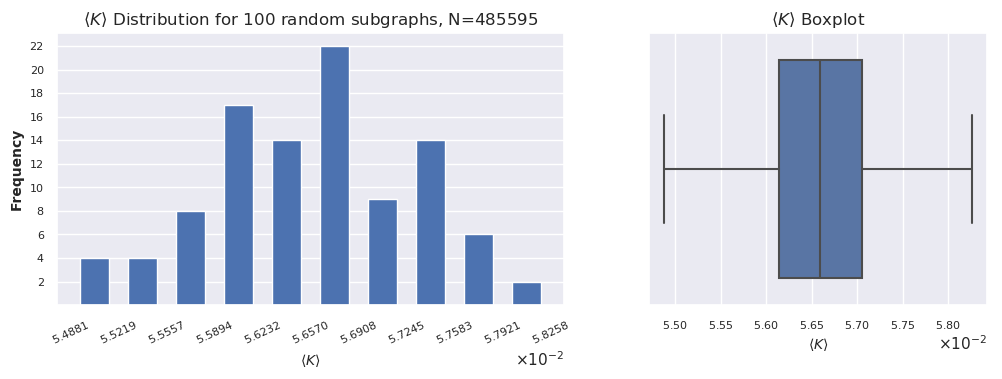

In [24]:
random_subgraphs_avg_degrees = [(2.0*rnd.GetEdges())/rnd.GetNodes() for rnd in random_subgraphs]
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": r"$\langle K \rangle$",
    "y_label": "Frequency",
    "hist_title": r"$\langle K \rangle$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$\langle K \rangle$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_average_degree_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_degrees, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

In [25]:
print("Average Degree random subgraphs: %.10f" %get_mean_from_distribution(random_subgraphs_avg_degrees))

Average Degree random subgraphs: 0.0565947755


## 3.4 Median Degree Comparison

In [26]:
def get_median_degree(graph):
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(rnd, DegToCntV)
    deg_counter = [(el.GetVal1(), el.GetVal2()) for el in DegToCntV]
    return max(deg_counter, key=lambda x: x[1])

random_median_degrees = [get_median_degree(rnd) for rnd in random_subgraphs]
hashtag_median_degree = get_median_degree(hashtag_subgraph)
print("The median degree for the hashtag network is: %d" %hashtag_median_degree[0])
print("The unique values of median degrees for all random networks are:")
print(list(set(map(lambda x: x[0], random_median_degrees))))

The median degree for the hashtag network is: 0
The unique values of median degrees for all random networks are:
[0]


Apparently the median degree (i.e. the degree that most of the nodes in the network have) of each random subgraph is 0, which means that the random networks have a high number of **isolated nodes** (i.e. *Zero-Degree nodes*) compared to the hashtag subgraph. Let's show more info about the Zero-Degree nodes:

In [27]:
hashtag_zero_deg_nodes = snap.CntDegNodes(hashtag_subgraph, 0)
avg_random_zero_deg_nodes = np.mean([snap.CntDegNodes(rnd, 0) for rnd in random_subgraphs])
print("Hashtag subgraph has %d Zero-Degree nodes (%.2f%% of %d)" %(hashtag_zero_deg_nodes, get_relative_percentage(hashtag_zero_deg_nodes,N), N))
print("Random subgraphs (on average) have %.3f Zero-Degree nodes (%.2f%% of %d)" %(avg_random_zero_deg_nodes, get_relative_percentage(avg_random_zero_deg_nodes,N), N))

Hashtag subgraph has 100963 Zero-Degree nodes (20.79% of 485595)
Random subgraphs (on average) have 462516.850 Zero-Degree nodes (95.25% of 485595)


| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| Average Degree $\langle K \rangle$ | 14,131 | ~0,056
| Median Degree $\tilde{K}$ | 0 | 0
| Zero-Degree Nodes | 100.963  | 462.516,850
| % Zero-Degree Nodes Relative to $N$ | 20.79% | 95,25%

## 3.5 Degree Distribution Comparison
By comparing the degree distribution we would be able to sum up whatever has been said concerning the degree-related properties of the subgraphs.

In [28]:
# Get degree distribution of hashtag subgraph
def get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N):
    DegToCntV_H = snap.TIntPrV()
    snap.GetDegCnt(hashtag_subgraph, DegToCntV_H)
    return [(item.GetVal1(), item.GetVal2() * 1.0 / N) for item in DegToCntV_H]

# Get mean of degree distributions of random subgraphs
# Get a unique list and do the average of the same degrees frequencies
def get_degree_distribution_random_subgraphs(random_subgraphs, N):
    random_degree_distribution = {} # Save degree values as keys and list of frequencies as values
    for rnd in random_subgraphs:
        DegToCntV_rnd = snap.TIntPrV()
        snap.GetDegCnt(rnd, DegToCntV_rnd)
        for el in DegToCntV_rnd:
            if el.GetVal1() in random_degree_distribution:
                random_degree_distribution[el.GetVal1()].append(el.GetVal2())
            else:
                random_degree_distribution[el.GetVal1()] = [el.GetVal2()]

    # Calculate average value for each degree
    for key in random_degree_distribution:
        random_degree_distribution[key] = np.mean(random_degree_distribution[key])*1.0/N

    # Convert to dict
    return random_degree_distribution.items()

In [29]:
random_degree_distribution = get_degree_distribution_random_subgraphs(random_subgraphs, N)
hashtag_subgraph_degree_distribution = get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N)

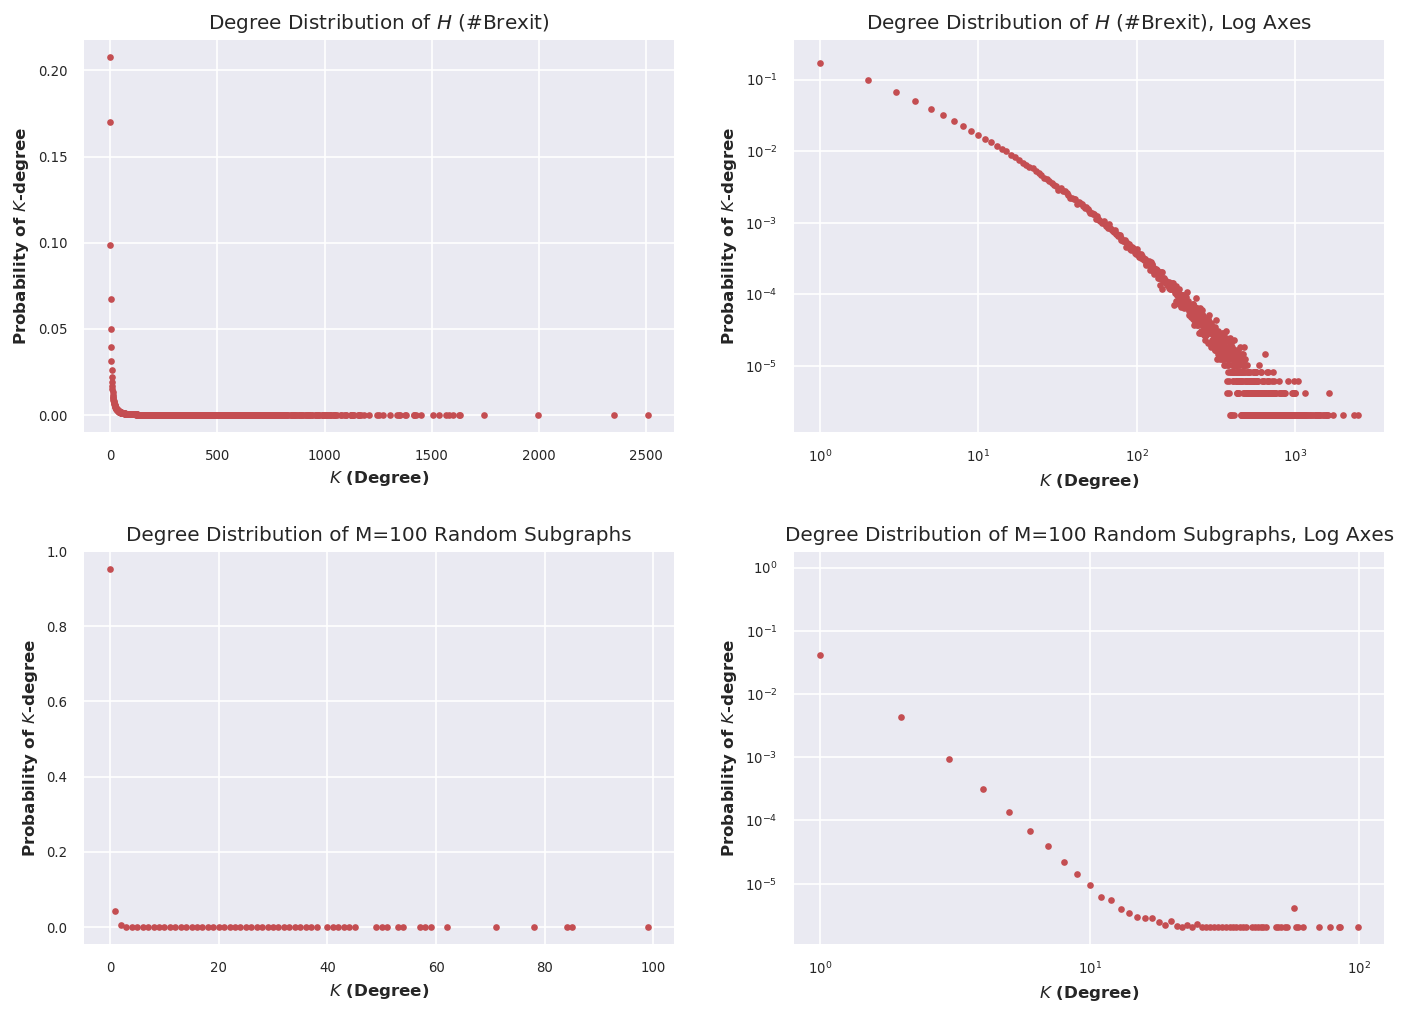

In [30]:
linestyle = "r."
labels_dict = {
    "x_label": r"$K$ (Degree)",
    "y_label": r"Probability of $K$-degree",
    "hashtag_normal_title": r"Degree Distribution of $H$ (%s)" %hashtag_full,
    "random_normal_title": "Degree Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"Degree Distribution of $H$ (%s), Log Axes" %hashtag_full,
    "random_log_title": "Degree Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_subgraph_degree_distribution, random_degree_distribution, labels_dict, linestyle, hashtag_full,"deg_dist_comparison_with_random")

## 3.6 Graph Density Comparison
The density $D$ of a network measures the ratio between the number of *actual connections* and the *potential connections*:

$$D=\frac{L}{L_{max}}$$

Given that, in a network with $N$ nodes, the potential connections in a graph are $L_{max}=\frac{N(N-1)}{2}$, the density is defined as:

$$D=\frac{2L}{N(N-1)}$$

In [31]:
def get_graph_density(graph):
    edges = graph.GetEdges()
    nodes = graph.GetNodes()
    return 2.0*edges/(nodes*(nodes-1))

hashtag_density = get_graph_density(hashtag_subgraph)
random_subgraphs_density = [get_graph_density(rnd) for rnd in random_subgraphs]
print("Hashtag subgraph density: %f" %hashtag_density)

Hashtag subgraph density: 0.000029


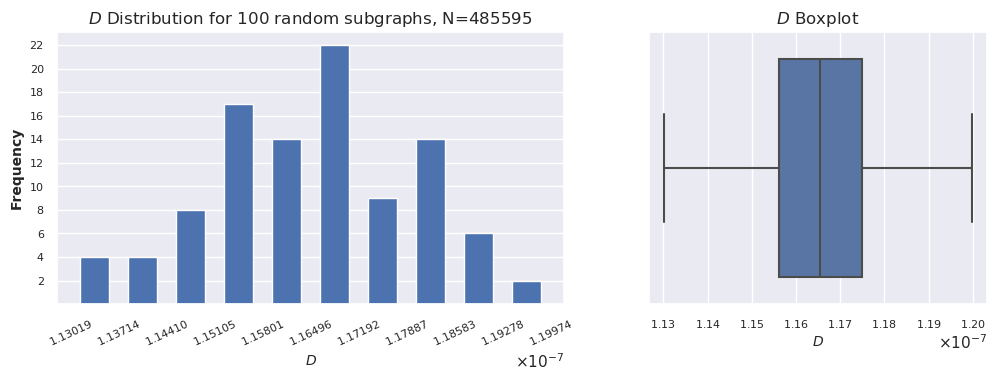

In [32]:
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": r"$D$",
    "y_label": "Frequency",
    "hist_title": r"$D$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$D$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_graph_density_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_density, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

In [33]:
print("Average random subgraphs density: %.10f" %get_mean_from_distribution(random_subgraphs_density))

Average random subgraphs density: 0.0000001165


## 3.7 Clustering Coefficient Comparison
The clustering coefficient captures the degree to which the neighbors of a given node link to each other. For a node $i$ with degree $k_i$ the local clustering coefficient is defined as:

$$C_i=\frac{2L_i}{k_i(k_i-1)}$$

where $L_i$ represents the number of links between the $k_i$ neighbors of node $i$. $C_i$ measures the network's local link density: The more densely interconnected the neighborhood of node $i$, the higher is its local clustering coefficient. The degree of clustering of a whole network is captured by the average clustering coefficient, $\langle C \rangle$, representing the average of $C_i$ over all nodes $i=1,\dots,N$.

I'm going to first compare the values of $\langle C \rangle$ between $H$ and the random subgraphs with the standard values distribution histogram. Then, I'll also compare the distribution of the clustering coefficient *by degree*, which would show how the values of the average clust. coefficient for nodes of each degree vary. Finally, the *global clustering coefficient* will also be analyzed.

In [34]:
hashtag_clustering_coeff = snap.GetClustCf(hashtag_subgraph, -1)
print("Hashtag subgraph average clustering coefficient: %.3f" %hashtag_clustering_coeff)

Hashtag subgraph average clustering coefficient: 0.112


In [35]:
# Just calculate average clust. coefficient for each random subgraph and show distribution
random_subgraphs_cf = [snap.GetClustCf(rnd, -1) for rnd in random_subgraphs]

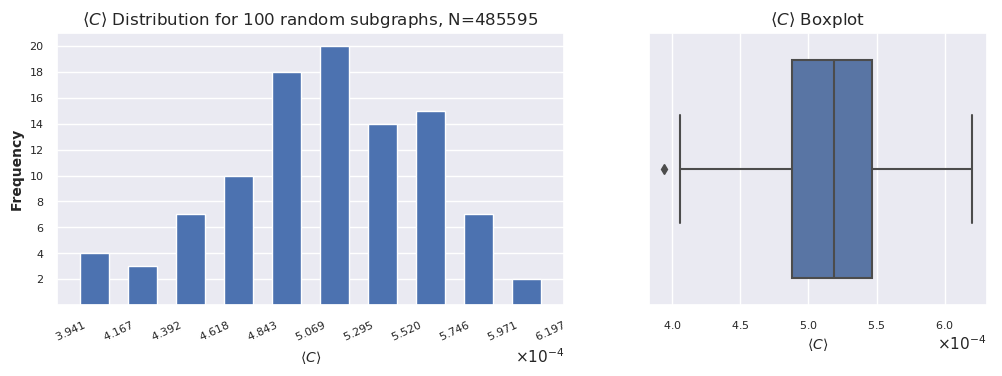

In [36]:
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": r"$\langle C \rangle$",
    "y_label": "Frequency",
    "hist_title": r"$\langle C \rangle$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$\langle C \rangle$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_avg_clust_coeff_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cf, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

In [41]:
print("Average random subgraphs clustering coefficient: %.10f" %get_mean_from_distribution(random_subgraphs_cf))

Average random subgraphs clustering coefficient: 0.0005142299


In [38]:
def get_clust_coeff_distribution_hashtag_subgraph(hashtag_subgraph):
    CfVec = snap.TFltPrV()
    snap.GetClustCf(hashtag_subgraph, CfVec, -1)
    return [(item.GetVal1(), item.GetVal2()) for item in CfVec]

def get_clust_coeff_distribution_random_subgraphs(random_subgraphs):
    random_clust_coeff_distribution = {}
    for rnd in random_subgraphs:
        CfVec_rnd = snap.TFltPrV()
        snap.GetClustCf(rnd, CfVec_rnd, -1)
        for pair in CfVec_rnd:
            if pair.GetVal1() in random_clust_coeff_distribution:
                random_clust_coeff_distribution[pair.GetVal1()].append(pair.GetVal2())
            else:
                random_clust_coeff_distribution[pair.GetVal1()] = [pair.GetVal2()]

    # Calculate average value for each degree
    for key in random_clust_coeff_distribution:
        random_clust_coeff_distribution[key] = np.mean(random_clust_coeff_distribution[key])

    # Convert to dict
    return random_clust_coeff_distribution.items()

In [39]:
random_avg_clust_coeff_distribution = get_clust_coeff_distribution_random_subgraphs(random_subgraphs)
hashtag_avg_clust_coeff_distribution = get_clust_coeff_distribution_hashtag_subgraph(hashtag_subgraph)

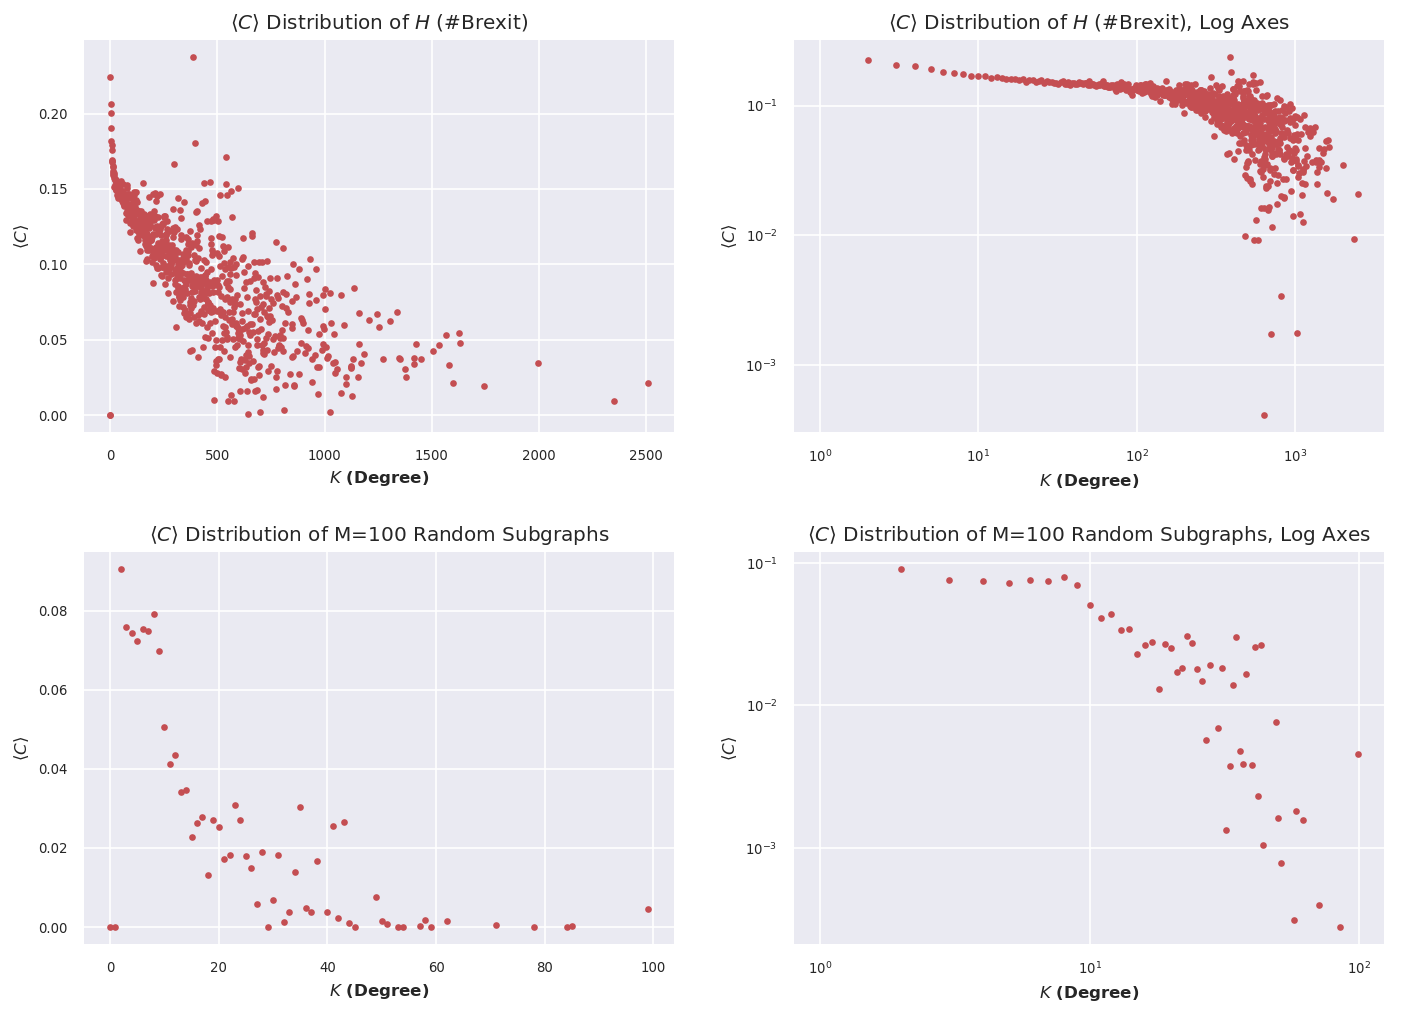

In [40]:
linestyle = "r."
labels_dict = {
    "x_label": r"$K$ (Degree)",
    "y_label": r"$\langle C \rangle$",
    "hashtag_normal_title": r"$\langle C \rangle$ Distribution of $H$ (%s)" %hashtag_full,
    "random_normal_title": r"$\langle C \rangle$ Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"$\langle C \rangle$ Distribution of $H$ (%s), Log Axes" %hashtag_full,
    "random_log_title": r"$\langle C \rangle$ Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_avg_clust_coeff_distribution, random_avg_clust_coeff_distribution, labels_dict, linestyle, hashtag_full,"avg_clust_coeff_comparison_with_random")

## 3.8 Connected Components Comparison
Let's first compare the size of the **largest connected component** ($MaxCC$) for $H$ and the random subgraphs:

In [42]:
hashtag_max_scc = snap.GetMxScc(hashtag_subgraph)
print("H Largest Connected Component Properties\n%d nodes (%.2f%% of %d total nodes and %.2f%% of %d Non-Zero Degree nodes)" %(hashtag_max_scc.GetNodes(),hashtag_max_scc.GetNodes()*100.0/N, N, hashtag_max_scc.GetNodes()*100.0/snap.CntNonZNodes(hashtag_subgraph), snap.CntNonZNodes(hashtag_subgraph)))
print("%d edges (%.2f%% of %d total edges)" %(hashtag_max_scc.GetEdges(), hashtag_max_scc.GetEdges()*100.0/L, L))

H Largest Connected Component Properties
377506 nodes (77.74% of 485595 total nodes and 98.15% of 384632 Non-Zero Degree nodes)
3426764 edges (99.88% of 3430912 total edges)


In [43]:
random_subgraphs_cc = [snap.GetMxScc(rnd) for rnd in random_subgraphs]

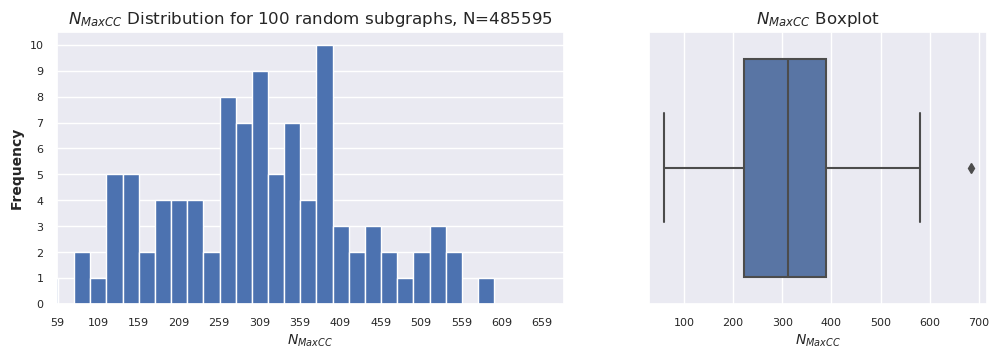

In [54]:
random_subgraphs_cc_nodes = [max_cc.GetNodes() for max_cc in random_subgraphs_cc]
rwidth = 1
binwidth = 20
xticks = range(min(random_subgraphs_cc_nodes),max(random_subgraphs_cc_nodes)+1, 50)
x_ticks_rotation = 0
labels_dict = {
    "x_label": r"$N_{MaxCC}$",
    "y_label": "Frequency",
    "hist_title": r"$N_{MaxCC}$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$N_{MaxCC}$ Boxplot"
}
y_ticks_step = 1
bottom_adjust = 0.2
filename = "random_subgraphs_max_cc_nodes_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cc_nodes, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, discrete_values=True, binwidth=binwidth, xticks=xticks)

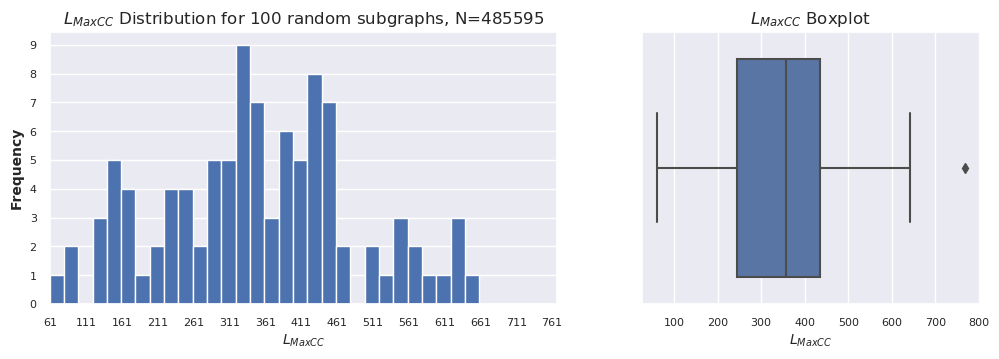

In [55]:
random_subgraphs_cc_edges = [max_cc.GetEdges() for max_cc in random_subgraphs_cc]
rwidth = 1
binwidth = 20
xticks = range(min(random_subgraphs_cc_edges),max(random_subgraphs_cc_edges)+1, 50)
x_ticks_rotation = 0
labels_dict = {
    "x_label": r"$L_{MaxCC}$",
    "y_label": "Frequency",
    "hist_title": r"$L_{MaxCC}$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$L_{MaxCC}$ Boxplot"
}
y_ticks_step = 1
bottom_adjust = 0.2
filename = "random_subgraphs_max_cc_edges_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cc_edges, hashtag_full, filename, M, N, labels_dict, rwidth, y_ticks_step=y_ticks_step, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, discrete_values=True, binwidth=binwidth, xticks=xticks)

In [46]:
print("Random subgraphs average N(MaxCC): %.2f" % get_mean_from_distribution(random_subgraphs_cc_nodes))
print("Random subgraphs average L(MaxCC): %.2f" % get_mean_from_distribution(random_subgraphs_cc_edges))

Random subgraphs average N(MaxCC): 313.88
Random subgraphs average L(MaxCC): 354.29


In [47]:
def get_cc_sizes_distribution_hashtag_subgraph(hashtag_subgraph):
    ComponentDist = snap.TIntPrV()
    snap.GetSccSzCnt(hashtag_subgraph, ComponentDist)
    return [(item.GetVal1(), item.GetVal2()) for item in ComponentDist]

def get_cc_sizes_distribution_random_subgraphs(random_subgraphs):
    random_cc_sizes_distribution = {}
    for rnd in random_subgraphs:
        ComponentDist = snap.TIntPrV()
        snap.GetSccSzCnt(rnd, ComponentDist)
        for pair in ComponentDist:
            if pair.GetVal1() in random_cc_sizes_distribution:
                random_cc_sizes_distribution[pair.GetVal1()].append(pair.GetVal2())
            else:
                random_cc_sizes_distribution[pair.GetVal1()] = [pair.GetVal2()]

    # Calculate average value
    for key in random_cc_sizes_distribution:
        random_cc_sizes_distribution[key] = np.mean(random_cc_sizes_distribution[key])

    # Convert to dict
    return random_cc_sizes_distribution.items()

In [48]:
random_cc_sizes_distribution = get_cc_sizes_distribution_random_subgraphs(random_subgraphs)
hashtag_cc_sizes_distribution = get_cc_sizes_distribution_hashtag_subgraph(hashtag_subgraph)

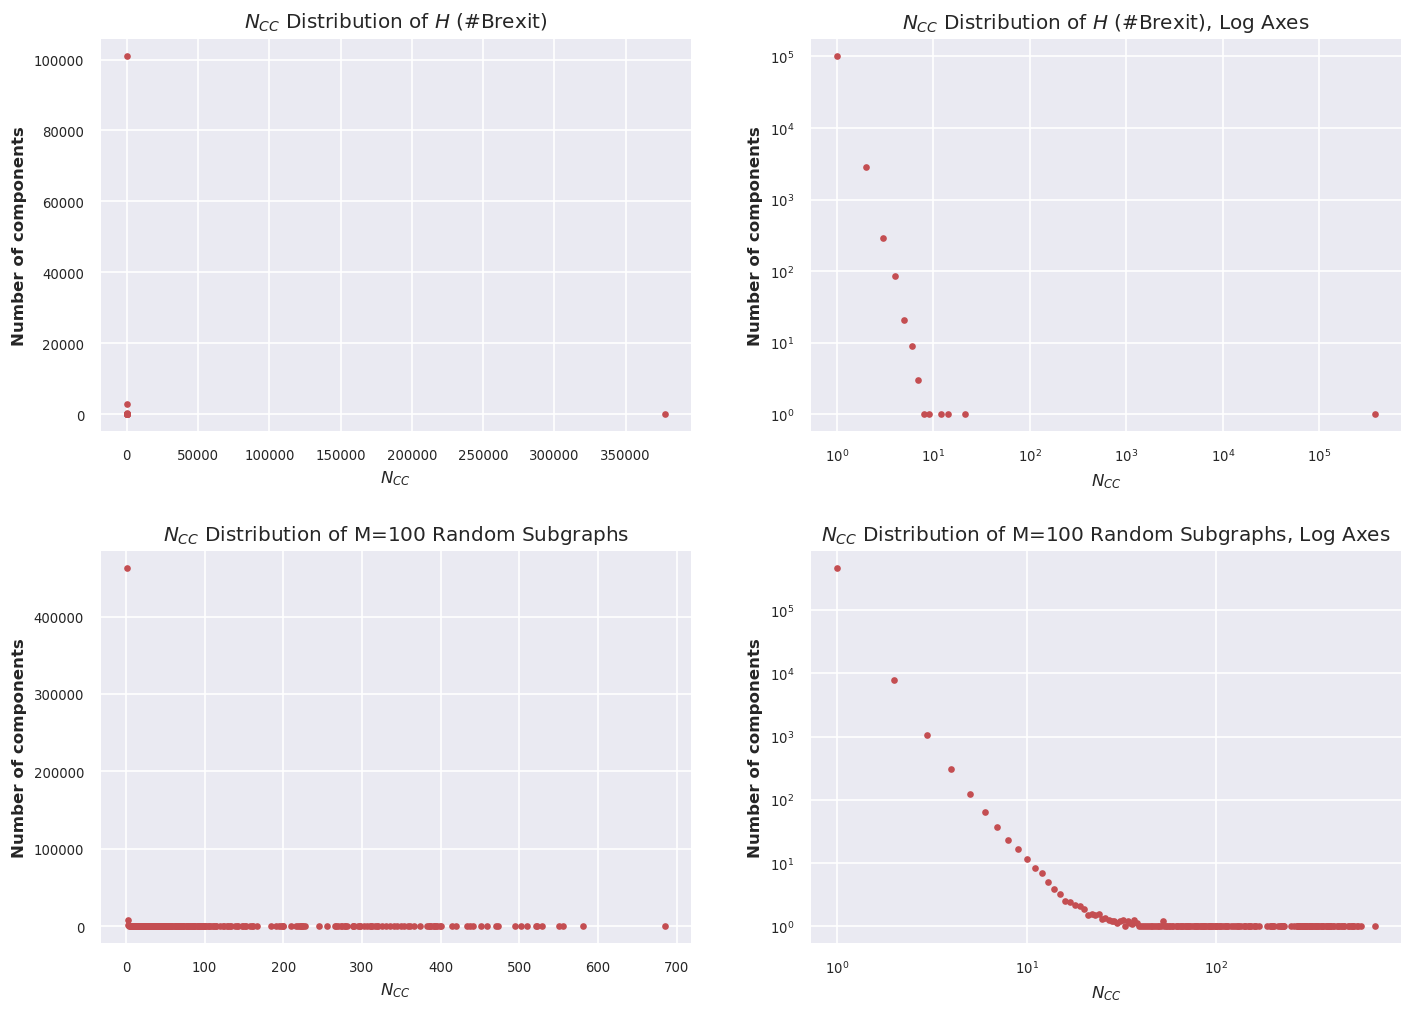

In [49]:
linestyle = "r."
labels_dict = {
    "x_label": r"$N_{CC}$",
    "y_label": "Number of components",
    "hashtag_normal_title": r"$N_{CC}$ Distribution of $H$ (%s)" %hashtag_full,
    "random_normal_title": r"$N_{CC}$ Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"$N_{CC}$ Distribution of $H$ (%s), Log Axes" %hashtag_full,
    "random_log_title": r"$N_{CC}$ Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_cc_sizes_distribution, random_cc_sizes_distribution, labels_dict, linestyle, hashtag_full,"cc_sizes_comparison_with_random")

In [50]:
print("%d components + %d isolated" %(sum(map(lambda x: x[1], hashtag_cc_sizes_distribution[1:])), hashtag_cc_sizes_distribution[0][1]))

3252 components + 100963 isolated


In [51]:
print("%.2f components + %.2f isolated" %(sum(map(lambda x: x[1], random_cc_sizes_distribution[1:])), random_cc_sizes_distribution[0][1]))

9711.24 components + 462516.85 isolated


In [52]:
print("(Hashtag subgraph) Percentage of Nodes of MaxCC relative to N: %.2f%%" % get_relative_percentage(hashtag_max_scc.GetNodes(), N))
print("(Random subgraphs) Percentage of Nodes of MaxCC relative to N: %.2f%%" % get_relative_percentage(get_mean_from_distribution(random_subgraphs_cc_nodes), N))
print("(Hashtag subgraph) Percentage of Nodes of MaxCC relative to N(k>0): %.2f%%" % get_relative_percentage(hashtag_max_scc.GetNodes(), snap.CntNonZNodes(hashtag_subgraph)))
print("(Random subgraphs) Percentage of Nodes of MaxCC relative to N(k>0): %.2f%%" % get_relative_percentage(get_mean_from_distribution(random_subgraphs_cc_nodes), get_mean_from_distribution([snap.CntNonZNodes(rnd) for rnd in random_subgraphs])))

(Hashtag subgraph) Percentage of Nodes of MaxCC relative to N: 77.74%
(Random subgraphs) Percentage of Nodes of MaxCC relative to N: 0.06%
(Hashtag subgraph) Percentage of Nodes of MaxCC relative to N(k>0): 98.15%
(Random subgraphs) Percentage of Nodes of MaxCC relative to N(k>0): 1.36%


| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| $N_{MaxCC}$ | 377.506 | ~288,65
| % $N_{MaxCC}$ Relative to $N$ | 77,74% | ~0,06%
| % $N_{MaxCC}$ Relative to $N_{k \gt 0}$ | 98,15% | ~1,36%
| Total components ($N_{CC}\geq 2$) | 3252 | ~9711,24

## 3.9 Shortest Path Lengths Comparison
Another relevant key metric for networks is what is commonly used as a measure for **distance**. We're not talking about physical distance, since in networks distance is translated into **path length**, where a path between two nodes $x$ and $y$ is the set of links that may be traversed to reach $y$ from $x$. The length of the path is therefore the number of traversed links. Usually the connotation of path length goes along with **shortest path length**. It would be interesting to get information about the ***average* shortest path length** $\langle d \rangle$, the **distribution of the shortest path lengths** and the **network diameter** $d_{max}$ (the longest shortest path in a graph, or the distance between the two furthest nodes). Along with $d_{max}$, usually there's an additional metric related to shortest path lengths known as **effective diameter** $d_{eff}$: the 90-th percentile of the distribution of shortest path lengths, or in other words, the minimal distance such that 90% of paths are at most at that distance from each other.

In order to consider meaningful results, I may restrict this comparison to the largest connected component $MaxCC$ of $H$ and the random subgraphs.

$\langle d \rangle$ is the fraction between the sum of all-pairs shortest-path length of the graph and the total number of all shortest paths that exist in the graph. Assuming that we're only working with connected components, the latter is always $N(N-1)$:

$$\langle d \rangle = \frac{\sum_{i,j}^N d_{i,j}}{N(N-1)}$$

In [56]:
# Functions used to calculate average shortest path length, diameter and shortest path lengths distribution for hashtag and random subgraphs
def calculate_shortest_path_lengths_distribution(graph, hashtag):
    start = time.time()
    print("Calculating shortest path lengths distribution...")
    snap.PlotShortPathDistr(graph, hashtag+"_shortestPathLengthsDist", "Shortest Path Lengths Distribution")
    end = time.time()
    print("Completed in: %s" %timedelta(seconds=(int(end-start))))
    
def calculate_shortest_path_lengths_distribution_random(graph, hashtag, rnd_index):
    snap.PlotShortPathDistr(graph,hashtag+"_random"+str(rnd_index)+"_shortestPathLengthsDist", "Shortest Path Lengths Distribution")

def read_aspl_diam(filename):
    with open("temp_results/diam."+filename+"_shortestPathLengthsDist.tab") as fin:
        content = fin.read()
        aspl = float(re.search(r'avg:(\d+\.?\d*)', content).group(1))
        eff_diam = float(re.search(r'eff:(\d+\.?\d*)', content).group(1))
        max_diam = int(re.search(r'max:(\d+\.?\d*)', content).group(1))
    return aspl,eff_diam,max_diam
    
def read_shortest_path_lengths_distribution(filename):
    return pd.read_csv("temp_results/diam."+filename+"_shortestPathLengthsDist.tab",sep="\t",skiprows=4,header=None, names=["Hops","Shortest Paths"], dtype={"Hops": np.uint32, "Shortest Paths": np.uint32})

I got these results for $H$:

In [84]:
hashtag_aspl, hashtag_eff_diam, hashtag_max_diam = read_aspl_diam(hashtag)
print("Average shortest path length: %.2f\nEffective Diameter: %.2f\nMax Diameter: %d" %(hashtag_aspl, hashtag_eff_diam, hashtag_max_diam))

Average shortest path length: 5.03
Effective Diameter: 7.89
Max Diameter: 20


Calculating these properties for the random graphs should be significantly quicker, due to the size of their largest connected components compared to $H$.

In [57]:
# Compute and save results to file by default
for i,rnd in enumerate(random_subgraphs_cc):
    calculate_shortest_path_lengths_distribution_random(rnd, hashtag, i)
    if i%10==0 and i!=0:
        print("Processed %d random subgraphs..." %i)
print("Done!")

Processed 10 random subgraphs...
Processed 20 random subgraphs...
Processed 30 random subgraphs...
Processed 40 random subgraphs...
Processed 50 random subgraphs...
Processed 60 random subgraphs...
Processed 70 random subgraphs...
Processed 80 random subgraphs...
Processed 90 random subgraphs...
Done!


In [58]:
def get_aspl_diam_random_subgraphs(random_subgraphs_cc, hashtag):
    aspl = []
    eff_diam = []
    max_diam = []
    for i,_ in enumerate(random_subgraphs_cc):
        rnd_aspl, rnd_eff_diam, rnd_max_diam = read_aspl_diam(hashtag+"_random"+str(i))
        aspl.append(rnd_aspl)
        eff_diam.append(rnd_eff_diam)
        max_diam.append(rnd_max_diam)
    return aspl, eff_diam, max_diam

def get_spl_distribution_random_subgraphs(random_subgraphs_cc, hashtag):
    random_spl_distribution = {}
    for i,_ in enumerate(random_subgraphs_cc):
        # Read back results in a Pandas Dataframe
        df = read_shortest_path_lengths_distribution(hashtag+"_random"+str(i))
        for _,r in df.iterrows():
            if r["Hops"] in random_spl_distribution:
                random_spl_distribution[r["Hops"]].append(r["Shortest Paths"])
            else:
                random_spl_distribution[r["Hops"]] = [r["Shortest Paths"]]

    # Calculate average value
    for key in random_spl_distribution:
        random_spl_distribution[key] = np.mean(random_spl_distribution[key])

    # Convert to dict
    return random_spl_distribution.items()

In [87]:
# Read back results
random_subgraphs_spl_distribution = get_spl_distribution_random_subgraphs(random_subgraphs_cc, hashtag)
random_subgraphs_aspl, random_subgraphs_eff_diam, random_subgraphs_max_diam = get_aspl_diam_random_subgraphs(random_subgraphs_cc, hashtag)

Let's now plot the distribution of the $\langle d \rangle$, $d_{eff}$ and $d_{max}$ for the random subgraphs and compare with the values obtained for $H$:

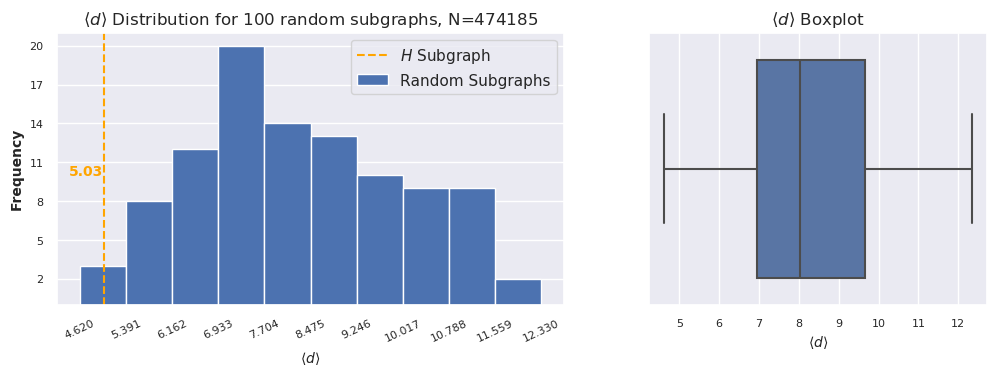

In [91]:
hashtag_text_x_offset = -0.6
rwidth = 1
y_ticks_step = 3
x_ticks_rotation = 25
labels_dict = {
    "x_label": r"$\langle d \rangle$",
    "y_label": "Frequency",
    "hist_title": r"$\langle d \rangle$ Distribution for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": r"$\langle d \rangle$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_aspl_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_aspl, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, compare_with_hashtag=True, hashtag_value=hashtag_aspl, hashtag_text_x_offset=hashtag_text_x_offset)

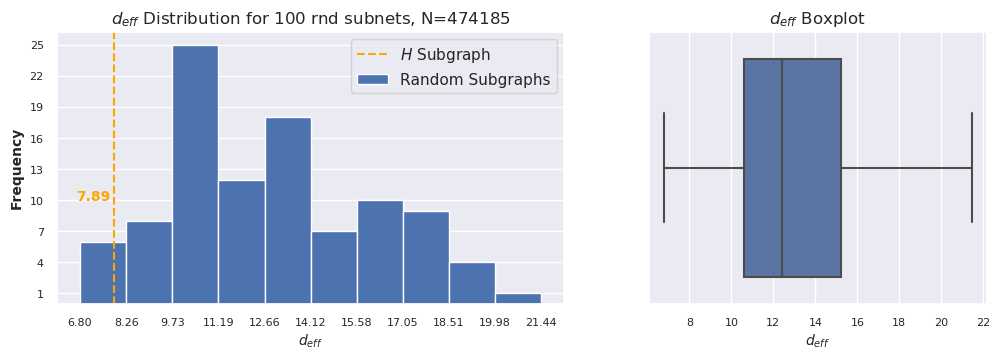

In [97]:
hashtag_text_x_offset = -1.2
rwidth = 1
y_ticks_step = 3
x_ticks_rotation = 0
labels_dict = {
    "x_label": r"$d_{eff}$",
    "y_label": "Frequency",
    "hist_title": r"$d_{eff}$ Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": r"$d_{eff}$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_eff_diam_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_eff_diam, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, compare_with_hashtag=True, hashtag_value=hashtag_eff_diam, hashtag_text_x_offset=hashtag_text_x_offset)

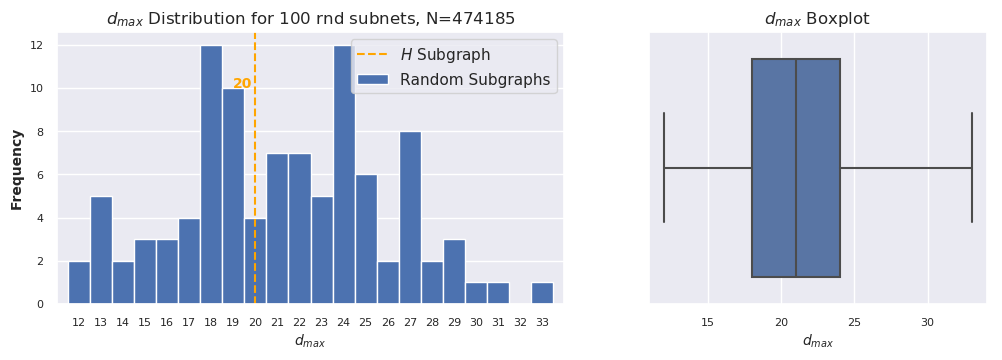

In [100]:
hashtag_text_x_offset = -1
rwidth = 1
y_ticks_step = 2
x_ticks_rotation = 0
xticks = range(min(random_subgraphs_max_diam),max(random_subgraphs_max_diam)+1)
#xticks = range(min(random_subgraphs_max_diam),hashtag_max_diam+1) # To use when hashtag value is greater than max of random dist
labels_dict = {
    "x_label": r"$d_{max}$",
    "y_label": "Frequency",
    "hist_title": r"$d_{max}$ Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": r"$d_{max}$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_max_diam_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_max_diam, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, discrete_values=True, xticks=xticks, compare_with_hashtag=True, hashtag_value=hashtag_max_diam, hashtag_text_x_offset=hashtag_text_x_offset)

In [101]:
print("Random subgraphs ASPL: %.3f" % get_mean_from_distribution(random_subgraphs_aspl))
print("Random subgraphs Effective Diameter: %.3f" % get_mean_from_distribution(random_subgraphs_eff_diam))
print("Random subgraphs Max Diameter: %.3f" % get_mean_from_distribution(random_subgraphs_max_diam))

Random subgraphs ASPL: 8.260
Random subgraphs Effective Diameter: 12.881
Random subgraphs Max Diameter: 21.230


| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| $\langle d \rangle$ | 5,03 | ~8,260
| $d_{eff}$ | 7,89 | ~12,881
| $d_{max}$ | 20 | ~21,23

Finally, the distribution of the shortest path lengths will provide an additional perspective to what has just been said: 

In [102]:
hashtag_spl_distribution = read_shortest_path_lengths_distribution(hashtag)
hashtag_spl_distribution = zip(list(hashtag_spl_distribution["Hops"]), list(hashtag_spl_distribution["Shortest Paths"]))

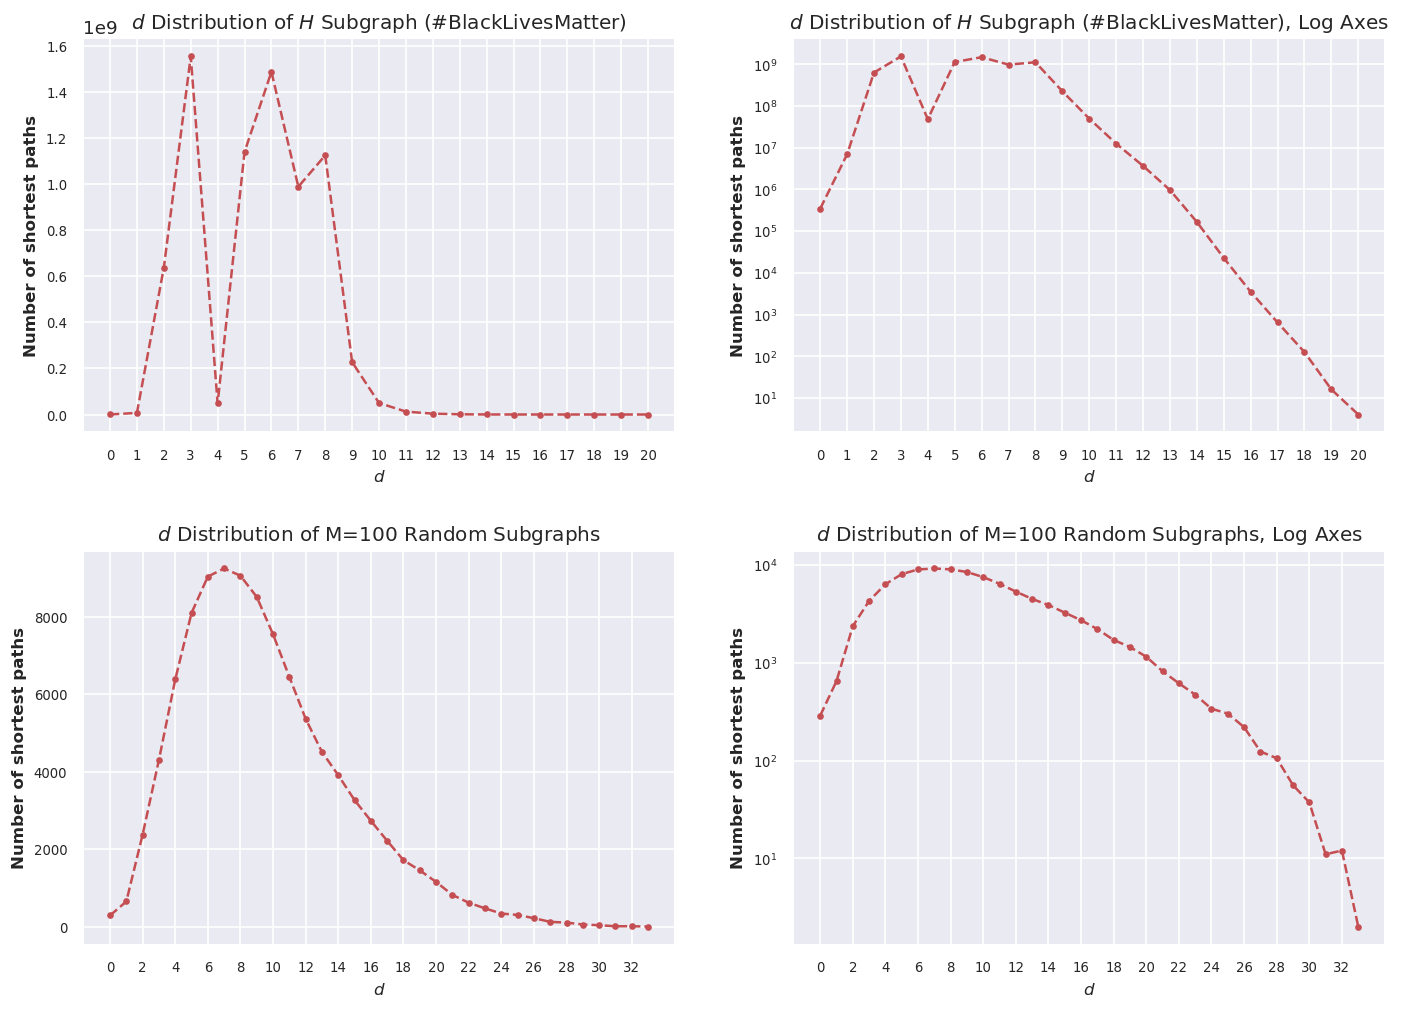

In [106]:
linestyle = "r.--"
xticks1 = range(min(map(lambda x: x[0], hashtag_spl_distribution)), max(map(lambda x: x[0], hashtag_spl_distribution))+1)
xticks2 = range(min(map(lambda x: x[0], random_subgraphs_spl_distribution)), max(map(lambda x: x[0], random_subgraphs_spl_distribution))+1, 2)
labels_dict = {
    "x_label": r"$d$",
    "y_label": "Number of shortest paths",
    "hashtag_normal_title": r"$d$ Distribution of $H$ Subgraph (%s)" %hashtag_full,
    "random_normal_title": r"$d$ Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"$d$ Distribution of $H$ Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": r"$d$ Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_spl_distribution, random_subgraphs_spl_distribution, labels_dict, linestyle, hashtag_full,"spl_comparison_with_random", log_axes="y", xticks1=xticks1, xticks2=xticks2)

## 3.10 Average Centrality Comparison
I may start computing relevant nodes rankings based on well known criteria in network science. **Centrality** provides a measure of node rankings which is helpful to identify the most important nodes in a network. But what does *important* mean? In order to avoid any ambiguity, there are different measures that adapt to different contexts when it comes to nodes *importance*. Since our network is fundamentally a social network, I'll try in this section to identify the most influential people. Usually, based on the nature of the network, different notions of centrality give different choices of the most central nodes. A ranking only orders nodes by importance, it does not quantify the difference in importance between different levels of the ranking. Furthermore, only the top ranked nodes actually reflect a meaningful result, whereas for the biggest majority of the other nodes the rankings may be meaningless.

For sake of comparison between $H$ and the random subgraphs, I may compare the values of for the **average centrality** for each of the centrality types that follow.

In [59]:
def get_hashtag_centrality(hashtag, centrality_type, filename):
    hashtag_centrality = pd.read_csv("temp_results/"+hashtag+"_"+filename+".csv", dtype={"Node": np.uint32, centrality_type: np.float32})
    hashtag_centrality.sort_values(by=centrality_type, inplace=True,ascending=False)
    hashtag_avg_centrality = np.mean(hashtag_centrality[centrality_type])
    print("H Average "+centrality_type+" is %f" %hashtag_avg_centrality)
    return hashtag_centrality, hashtag_avg_centrality

def show_top_centrality_scores(top_k, hashtag_centrality):
    node_ids = [int(el) for el in list(hashtag_centrality["Node"])[:top_k]]
    id_to_username_dict = get_multiple_usernames(node_ids)
    temp_df = pd.DataFrame(id_to_username_dict.items(), columns=["Node","Username"])
    cast_df_to_original_types(temp_df, ["Node","Username"], {"Node": np.uint32, "Username": np.str})
    hashtag_centrality = temp_df.merge(hashtag_centrality, on="Node")
    hashtag_centrality.sort_values(by=hashtag_centrality.columns[2], inplace=True,ascending=False)
    display(hashtag_centrality)
    return hashtag_centrality

### 3.10.1 Closeness Centrality
This measure is calculated as the reciprocal of the farness centrality, which is the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. The normalized version represents the average length of the shortest paths instead of their sum:

$C(i)=\frac{N}{\sum\nolimits_{j}d_{i,j}}$

where $d_{i,j}$ is the distance between nodes $i$ and $j$.

In [116]:
hashtag_closeness_centrality, hashtag_avg_closeness_centrality = get_hashtag_centrality(hashtag, "Closeness Centrality", "closeness_centrality")

H Average Closeness Centrality is 0.212662


In [61]:
def get_avg_closeness_centrality_random_subgraphs(random_subgraphs_cc):
    avg_closeness_centrality = []
    for rnd in random_subgraphs_cc:
        closeness_centrality_scores = []
        for node in rnd.Nodes():
            score = snap.GetClosenessCentr(rnd, node.GetId())
            if score == 0:
                continue
            closeness_centrality_scores.append(score)
        avg_closeness_centrality.append(np.mean(closeness_centrality_scores))
    return avg_closeness_centrality

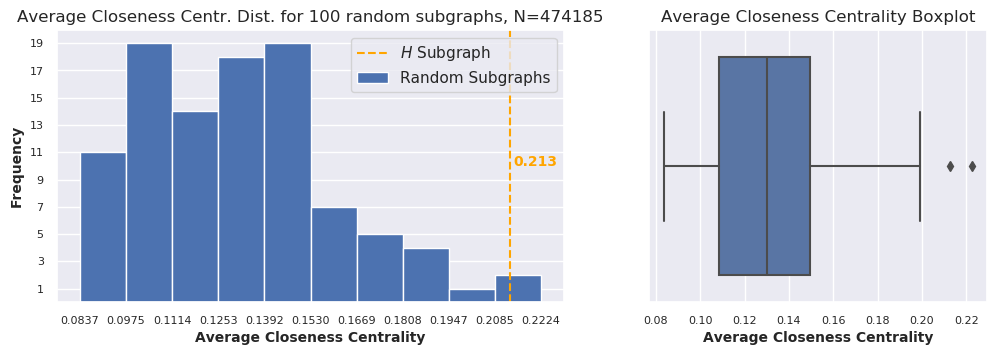

In [121]:
random_subgraphs_avg_closeness_centrality = get_avg_closeness_centrality_random_subgraphs(random_subgraphs_cc)
rwidth = 1
x_ticks_rotation = 0
hashtag_text_x_offset = 0.001
legend_pos = "upper right"
labels_dict = {
    "x_label": "Average Closeness Centrality",
    "y_label": "Frequency",
    "hist_title": "Average Closeness Centr. Dist. for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": "Average Closeness Centrality Boxplot"
}
bottom_adjust = 0.2
y_ticks_step = 2
filename = "random_subgraphs_avg_closeness_centrality"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_closeness_centrality, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, compare_with_hashtag=True, hashtag_value=round(hashtag_avg_closeness_centrality,3), hashtag_text_x_offset=hashtag_text_x_offset, legend_pos=legend_pos)

In [122]:
print("Random subgraphs average closeness centrality: %.3f" % get_mean_from_distribution(random_subgraphs_avg_closeness_centrality))

Random subgraphs average closeness centrality: 0.132


In [123]:
hashtag_closeness_centrality_top = show_top_centrality_scores(20, hashtag_closeness_centrality)

,Node,Username,Closeness Centrality
2,3084976,deray,0.326
8,509549,maggyw519,0.316
0,5571282,politicspeach,0.315
3,669675,reignofapril,0.315
14,1660484,docrocktex26,0.313
15,75060,nettaaaaaaaa,0.313
5,826061,blogdiva,0.312
6,38625214,shaunking,0.311
16,443524,rolandsmartin,0.311
10,648865,jamilahlemieux,0.311


### 3.10.3 Eigenvector Centrality
Eigenvector Centrality provides a measure of the influence of a node in a network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. Given a node $v$ and its set if neighbors $M(v)$ and a constant value $\lambda$, its eigenvector centrality score is given by:

$$eigen(v)=\frac{1}{\lambda}\sum_{t\in M(v)}eigen(t)=\frac{1}{\lambda}\sum_{t\in G}a_{t,v}eigen(t)$$

If we consider the adjacency matrix $A$ where each entry $a_{i,j} = 1$ if $i$ and $j$ are connected, $0$ otherwise, this may be re-written in eigenvector equation:

$$\mathbf{Ax}=\lambda\mathbf{x}$$

Since there will be many different eigenvalues $\lambda$  for which a non-zero eigenvector solution exists, but all the entries in the eigenvector have to be non-negative, the greatest eigenvalue is then chosen and the $v^{th}$ component of the related eigenvector then gives the relative centrality score of the vertex $v$ in the network.

In [124]:
hashtag_eigenvector_centrality, hashtag_avg_eigenvector_centrality = get_hashtag_centrality(hashtag, "Eigenvector Centrality", "eigenvector_centrality")

H Average Eigenvector Centrality is 0.000271


In [62]:
def get_avg_eigenvector_centrality_random_subgraphs(random_subgraphs_cc):
    avg_eigenvector_centrality = []
    for rnd in random_subgraphs_cc:
        NIdEigenH = snap.TIntFltH()
        snap.GetEigenVectorCentr(rnd, NIdEigenH)
        eigenvector_centrality_values = [NIdEigenH[node] for node in NIdEigenH if NIdEigenH[node] != 0]
        avg_eigenvector_centrality.append(np.mean(eigenvector_centrality_values))
    return avg_eigenvector_centrality

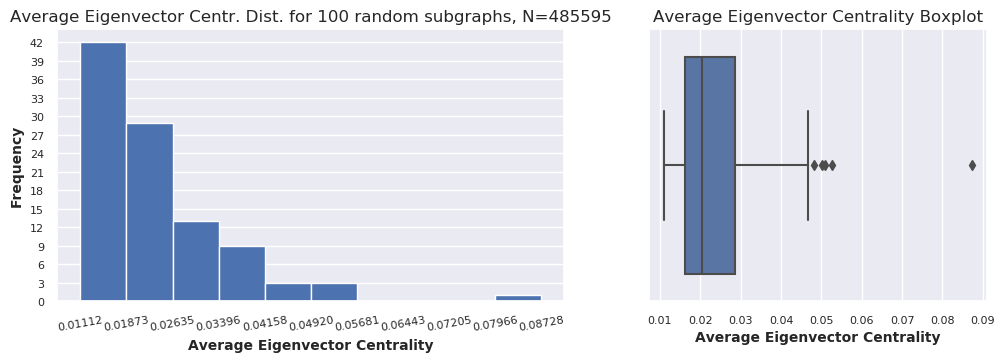

In [63]:
random_subgraphs_avg_eigenvector_centrality = get_avg_eigenvector_centrality_random_subgraphs(random_subgraphs_cc)
rwidth = 1
x_ticks_rotation = 10
labels_dict = {
    "x_label": "Average Eigenvector Centrality",
    "y_label": "Frequency",
    "hist_title": "Average Eigenvector Centr. Dist. for %d random subgraphs, N=%d" %(M, N),
    "boxplot_title": "Average Eigenvector Centrality Boxplot"
}
bottom_adjust = 0.2
y_ticks_step = 3
filename = "random_subgraphs_avg_eigenvector_centrality"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_eigenvector_centrality, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step)

In [64]:
print("Random subgraphs average eigenvector centrality: %.3f" % get_mean_from_distribution(random_subgraphs_avg_eigenvector_centrality))

Random subgraphs average eigenvector centrality: 0.024


In [133]:
hashtag_eigenvector_centrality_top = show_top_centrality_scores(20, hashtag_eigenvector_centrality)

,Node,Username,Eigenvector Centrality
18,47536,chucknellis,0.095
10,37148544,carminezozzora,0.085
11,478173,marylene58,0.083
4,26750,jjauthor,0.083
19,146875,blisstabitha,0.081
14,16722871,steph93065,0.078
17,4138742,lyndag1963,0.076
13,39120,klsouth,0.069
2,23531,pudingtane,0.067
1,114552,tracieeeeee,0.067


### 3.10.4 Centrality Results Summary
| Centrality (Average) | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| Closeness | 0,212662 | ~0,132
| Eigenvector | 0,000271 | ~0,026

In [135]:
hashtag_closeness_centrality_top.merge(hashtag_eigenvector_centrality_top)

,Node,Username,Closeness Centrality,Eigenvector Centrality
0,63750,politibunny,0.309,0.066
